# Predict soccer player performance


## Motivation
Can we predict the performance of soccer players with machine learning techniques?


<img style="float: left;" src="https://www.telegraph.co.uk/content/dam/football/2018/04/04/TELEMMGLPICT000151290412_trans_NvBQzQNjv4BqUkPY_iHoT60TfDGz0jFsaLEu4odvKfIxFVccPQZWyAc.jpeg?imwidth=1400" width="700px"/>

## Data Collection

### Team Historical Performance
- Team evaluation (defense/offense) and match prediction (chance to win/draw/lose) from FiveThirtyEight.com
  - csv to SQL
- Sportsbook odds (odds to win/draw/lose, odds of total goals greater than 2)
  - csv to SQL

### Player Historical Performance
- Detailed performance (goals, assistants, passes, etc.)
  - webpage to SQL (Selenium)

### Data Management with Multiple Sources
    - Relational database (SQL)
    - Player name match

## Data Processing

In [4]:
import pandas as pd
from sqlalchemy import create_engine
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm, skew
from scipy.special import boxcox1p
import numpy as np  
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split, cross_validate, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
import lightgbm as lgb
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [5]:
# load existing PlayerList db
disk_engine = create_engine('sqlite:///EPL1718.db')
player_data_df = pd.read_sql('player_data_extended', disk_engine)
print(player_data_df.shape)

(9582, 80)


In [3]:
# first glance of all data
player_data_df.head(5)  

,team_name_full_roto,team_name_three_letter_DK,player_name_roto,player_name_DK_salary,game_date,opponent,is_away_game,form,is_starting,minutes,...,BbAHh,BbMxAHH,BbAvAHH,BbMxAHA,BbAvAHA,PSCH,PSCD,PSCA,total_points,Position_DK
0,Arsenal,ARS,Hector Bellerin,Hector Bellerin,2017-12-10,SOU,b'\x00',3421,1,90,...,0.25,2.27,2.19,1.75,1.71,4.20,3.80,1.93,-0.25,D
1,Arsenal,ARS,Hector Bellerin,Hector Bellerin,2017-12-02,MUN,b'',3421,1,90,...,-0.25,2.14,2.10,1.85,1.80,2.32,3.43,3.36,0.25,D
2,Arsenal,ARS,Hector Bellerin,Hector Bellerin,2017-11-29,HUD,b'',3421,1,90,...,-2.00,2.10,2.04,1.90,1.83,1.18,8.30,18.50,5.25,D
3,Arsenal,ARS,Hector Bellerin,Hector Bellerin,2017-11-26,BUR,b'\x00',3421,1,90,...,1.00,1.95,1.90,2.03,1.97,6.25,4.20,1.61,6.00,D
4,Arsenal,ARS,Hector Bellerin,Hector Bellerin,2017-11-18,TOT,b'',3421,1,90,...,-0.25,2.19,2.11,1.83,1.78,2.49,3.50,3.00,2.75,D


### Target Variable: total_points
<img style="float: left;" src="https://dkstatic.s3.amazonaws.com/lp/2016-How-to-Play-FOT/Big-Time_Scoring.png" width="200px"/>


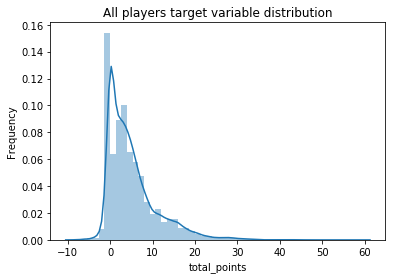

In [4]:
# take a look at the target variable original distribution
sns.distplot(player_data_df['total_points'])
plt.xlabel('total_points')
plt.ylabel('Frequency')
plt.title('All players target variable distribution')
plt.show()

### Remove Outliers

remove 2506 games that player not starting


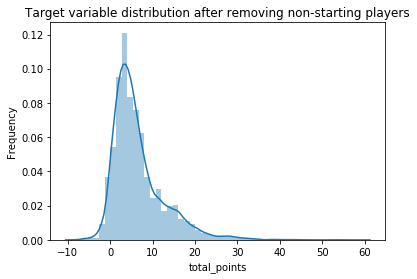

In [5]:
# remove players with not starting
print('remove', sum(player_data_df['is_starting'] != 1), 'games that player not starting')
plt.figure()
plt.xlabel('total_points')
plt.ylabel('Frequency')
plt.title('Target variable distribution after removing non-starting players')
sns.distplot(player_data_df[player_data_df['is_starting'] == 1]['total_points'])
plt.show()

remove 176 games that player early substitution


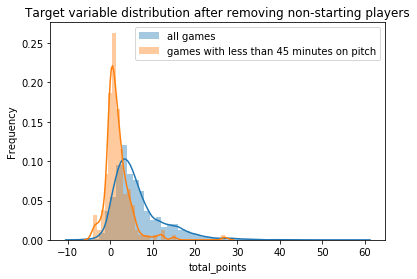

In [5]:
# remove outliers with early substitution (injury)
plt.figure()
plt.xlabel('total_points')
plt.ylabel('Frequency')
plt.title('Target variable distribution after removing non-starting players')
sns.distplot(player_data_df[player_data_df['is_starting'] == 1]['total_points'], label='all games')
print('remove', sum((player_data_df['minutes'] <= 45) & (player_data_df['is_starting'] == 1)),
      'games that player early substitution')
sns.distplot(player_data_df[(player_data_df['minutes'] <= 45) & (player_data_df['is_starting'] == 1)]['total_points'], label='games with less than 45 minutes on pitch');
plt.legend()
plt.show()

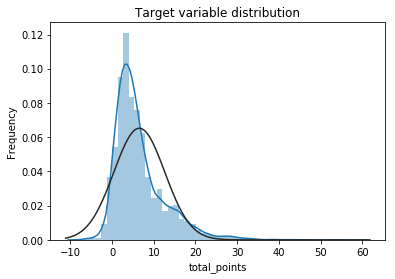

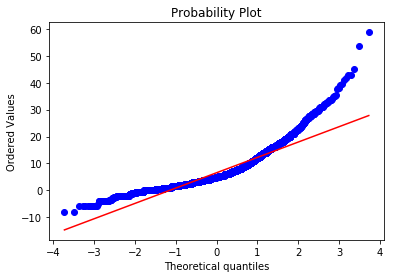

In [6]:
# How the target variable look like?
data_df = player_data_df.drop(
    player_data_df[(player_data_df['minutes'] <= 45) | (player_data_df['is_starting'] != 1)].index)
plt.figure()
plt.xlabel('total_points')
plt.ylabel('Frequency')
plt.title('Target variable distribution')
sns.distplot(data_df['total_points'], fit=norm)
plt.show()
fig = plt.figure()
res = stats.probplot(data_df['total_points'], plot=plt)  # Q-Q plot
plt.show()

In [8]:
# Remove individual outliers
data_df.sort_values(by='total_points', ascending=False).head(10)

,team_name_full_roto,team_name_three_letter_DK,player_name_roto,player_name_DK_salary,game_date,opponent,is_away_game,form,is_starting,minutes,...,BbAHh,BbMxAHH,BbAvAHH,BbMxAHA,BbAvAHA,PSCH,PSCD,PSCA,total_points,Position_DK
7299,Liverpool,LIV,Mohamed Salah,Mohamed Salah,2018-03-17,WAT,b'',433,1,90,...,-2.00,1.90,1.84,2.11,2.03,1.17,9.00,18.45,58.75,M/F
6287,Manchester City,MCI,Sergio Aguero,Sergio Aguero,2018-02-10,LEI,b'',433,1,90,...,-2.00,2.02,1.95,1.95,1.91,1.24,6.70,15.50,53.50,F
4282,Tottenham Hotspur,TOT,Harry Kane,Harry Kane,2017-12-23,BUR,b'\x00',4231,1,90,...,1.00,2.01,1.96,1.95,1.91,6.80,4.29,1.56,45.00,F
3116,Leicester City,LEI,Shinji Okazaki,Shinji Okazaki,2017-12-13,SOU,b'\x00',4231,1,90,...,-0.25,1.82,1.77,2.17,2.10,1.94,3.49,4.56,43.00,M/F
5389,Manchester City,MCI,Sergio Aguero,Sergio Aguero,2018-01-20,NEW,b'',433,1,90,...,-2.50,2.05,2.00,1.92,1.86,1.12,11.00,28.50,42.75,F
4281,Tottenham Hotspur,TOT,Harry Kane,Harry Kane,2017-12-26,SOU,b'',4231,1,90,...,-1.50,2.11,2.06,1.85,1.82,1.33,5.80,10.20,41.75,F
1868,Chelsea,CHE,Eden Hazard,Eden Hazard,2017-12-02,NEW,b'',3511,1,78,...,-1.75,2.05,2.00,1.95,1.88,1.24,6.65,16.50,41.00,M/F
1440,AFC Bournemouth,BOU,Callum Wilson,Callum Wilson,2017-11-18,HUD,b'',4411,1,90,...,-0.50,1.86,1.82,2.11,2.07,1.81,3.66,5.16,39.50,F
5557,Everton,EVE,Theo Walcott,Theo Walcott,2018-01-31,LEI,b'',4231,1,90,...,0.25,1.79,1.74,2.21,2.15,2.78,3.16,2.90,39.25,M/F
5933,Arsenal,ARS,Aaron Ramsey,Aaron Ramsey,2018-02-03,EVE,b'',4231,1,75,...,-1.75,2.18,2.11,1.81,1.77,1.37,5.45,9.50,38.00,M


In [9]:
data_df.sort_values(by='total_points').head(10)

,team_name_full_roto,team_name_three_letter_DK,player_name_roto,player_name_DK_salary,game_date,opponent,is_away_game,form,is_starting,minutes,...,BbAHh,BbMxAHH,BbAvAHH,BbMxAHA,BbAvAHA,PSCH,PSCD,PSCA,total_points,Position_DK
3903,Southampton,SOU,Fraser Forster,Fraser Forster,2017-12-26,TOT,b'\x00',4141,1,90,...,-1.50,2.11,2.06,1.85,1.82,1.33,5.80,10.20,-8.0,GK
442,Huddersfield Town,HUD,Jonas Lossl,Jonas Lossl,2017-11-29,ARS,b'\x00',3421,1,90,...,-2.00,2.10,2.04,1.90,1.83,1.18,8.30,18.50,-8.0,GK
2186,Brighton & Hove Albion,BHA,Mathew Ryan,Mat Ryan,2017-12-02,LIV,b'',4411,1,90,...,1.00,2.13,2.09,1.84,1.80,7.25,4.39,1.53,-6.0,GK
2597,Liverpool,LIV,Simon Mignolet,Simon Mignolet,2017-10-22,TOT,b'\x00',433,1,90,...,-0.25,1.93,1.88,2.03,1.99,2.24,3.62,3.36,-6.0,GK
3792,AFC Bournemouth,BOU,Asmir Begovic,Asmir Begovic,2017-12-23,MCI,b'\x00',3421,1,90,...,-2.75,2.01,1.93,1.99,1.94,1.09,15.00,27.00,-6.0,GK
5069,Huddersfield Town,HUD,Jonas Lossl,Jonas Lossl,2018-01-13,WHU,b'',4231,1,90,...,-0.25,2.32,2.22,1.73,1.70,2.94,3.11,2.79,-6.0,GK
444,Huddersfield Town,HUD,Jonas Lossl,Jonas Lossl,2017-11-18,BOU,b'\x00',4231,1,90,...,-0.50,1.86,1.82,2.11,2.07,1.81,3.66,5.16,-6.0,GK
6341,AFC Bournemouth,BOU,Asmir Begovic,Asmir Begovic,2018-02-11,HUD,b'\x00',3421,1,90,...,0.25,1.88,1.83,2.09,2.03,3.14,3.39,2.45,-6.0,GK
6217,Swansea City,SWA,Lukasz Fabianski,Lukasz Fabianski,2018-02-24,BHA,b'\x00',541,1,90,...,-0.25,1.80,1.77,2.19,2.11,2.01,3.31,4.53,-6.0,GK
207,Everton,EVE,Jordan Pickford,Jordan Pickford,2017-11-26,SOU,b'\x00',442,1,90,...,-0.75,2.20,2.15,1.82,1.75,1.81,3.72,5.00,-6.0,GK


In [15]:
# Remove individual outliers
data_df = data_df.sort_values(by='total_points', ascending=False).iloc[2:]  # drop the highest two games
print('after removing outliers, remaining games:', len(data_df))

after removing outliers, remaining games: 6898


### Data Transformation

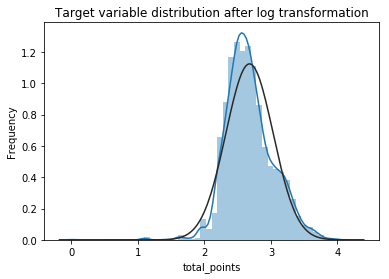

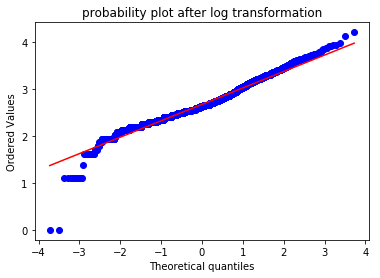

data size after pre-processing (7076, 80)


In [7]:
# fix skewness of the target variable
data_df['total_points'] = data_df['total_points'] - data_df['total_points'].min()
data_df['total_points'] = np.log1p(data_df['total_points'])
plt.figure()
plt.xlabel('total_points')
plt.ylabel('Frequency')
plt.title('Target variable distribution after log transformation')
sns.distplot(data_df['total_points'], fit=norm)
plt.show()
fig = plt.figure()
res = stats.probplot(data_df['total_points'], plot=plt)  # Q-Q plot
plt.title('probability plot after log transformation')
plt.show()
print('data size after pre-processing', data_df.shape)

### Missing Data

In [8]:
# Missing data
data_missing_percent = (data_df.isnull().sum() / len(data_df)) * 100
data_missing_percent = data_missing_percent.drop(data_missing_percent[data_missing_percent == 0].index).sort_values(
    ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio': data_missing_percent})
print(missing_data)

             Missing Ratio
FPTSPerGame      26.526286


In [9]:
# impute missing FPTSPerGame with average of previous FPTSPerGame
# data_df['FPTSPerGame'] = data_df['FPTSPerGame'].fillna(data_df[~data_df['FPTSPerGame'].isnull()]['FPTSPerGame'].median())
# Impute with median of available FPTSPerGame seems not appropriate
index_with_no_previous_FPTSPerGame = []
for index in data_df[data_df['FPTSPerGame'].isnull()].index:
    try:  # impute with the FPTSPerGame that was available on the most recent day
        data_df.loc[index, 'FPTSPerGame'] = data_df[(data_df['game_date'] < data_df['game_date'][index])
                                                & (data_df['player_name_roto'] == data_df['player_name_roto'][index])
                                                & (~data_df['FPTSPerGame'].isnull())].sort_values('game_date',
                                                                                                  ascending=False) \
            ['FPTSPerGame'].iloc[0]
    except IndexError:  # if no FPTSPerGame available before the game day -- remove game data
        index_with_no_previous_FPTSPerGame.append(index)
data_df = data_df.drop(index_with_no_previous_FPTSPerGame)
print('drop another', len(index_with_no_previous_FPTSPerGame),
      'with no previous FPTSPerGame available for impute, remaining:', data_df.shape)

drop another 330 with no previous FPTSPerGame available for impute, remaining: (6746, 80)


In [10]:
# Double check missing data
data_missing_percent = (data_df.isnull().sum() / len(data_df)) * 100
data_missing_percent = data_missing_percent.drop(data_missing_percent[data_missing_percent == 0].index).sort_values(
    ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio': data_missing_percent})
print(missing_data)

Empty DataFrame
Columns: [Missing Ratio]
Index: []


### Data Leakage

In [10]:
# remove team and player information, since first build a general model
player_name_DK_salary_df = data_df['player_name_DK_salary'] # save 'player_name_DK_salary' seperately for testing purpose
data_df = data_df.drop(
    columns=['team_name_full_roto', 'team_name_three_letter_DK', 'player_name_roto', 'opponent', 'player_name_DK_salary']) 

# remove is_starting since all players are starting
data_df = data_df.drop(columns=['is_starting'])

# remove minutes to prevent data leakage, since we do not know how long player will be playing before game
data_df = data_df.drop(columns=['minutes'])

### Skewed Features

In [11]:
# Check the skewness of all numerical variables
numeric_variables = data_df.dtypes[(data_df.dtypes != 'object') & (data_df.dtypes != 'datetime64[ns]')].index
skewed_variables = data_df[numeric_variables].apply(lambda x: skew(x)).abs().sort_values(ascending=False)
print("Top 10 absolute skewness in numerical variables: ")
skewness = pd.DataFrame({'Skew': skewed_variables})
print(skewness.head(10))
lam = 0.1
for variable_name in skewness[(skewness['Skew'] > 3)].index:  # fix the skew variables with Box Cox Transformation
    data_df[variable_name] = boxcox1p(data_df[variable_name], lam)

Top 10 absolute skewness in numerical variables: 
                         Skew
Win_League_per       4.234334
oppo_Win_League_per  4.119925
LBH                  2.568297
BbMxH                2.503379
VCH                  2.478780
B365H                2.411455
WHH                  2.392562
BbAvH                2.350756
PSCD                 2.298204
PSH                  2.296346


### Categorical Variable Encoding

In [12]:
# transform is_away_game from string to 0/1
data_df.loc[[ii == b'' for ii in data_df['is_away_game']], 'is_away_game'] = 0
data_df.loc[[ii != b'' for ii in data_df['is_away_game']], 'is_away_game'] = 1

# One-hot encoding for categorical data
data_df = pd.get_dummies(data_df)
print('all data shape:', data_df.shape)

all data shape: (6746, 112)


### Data Correlation

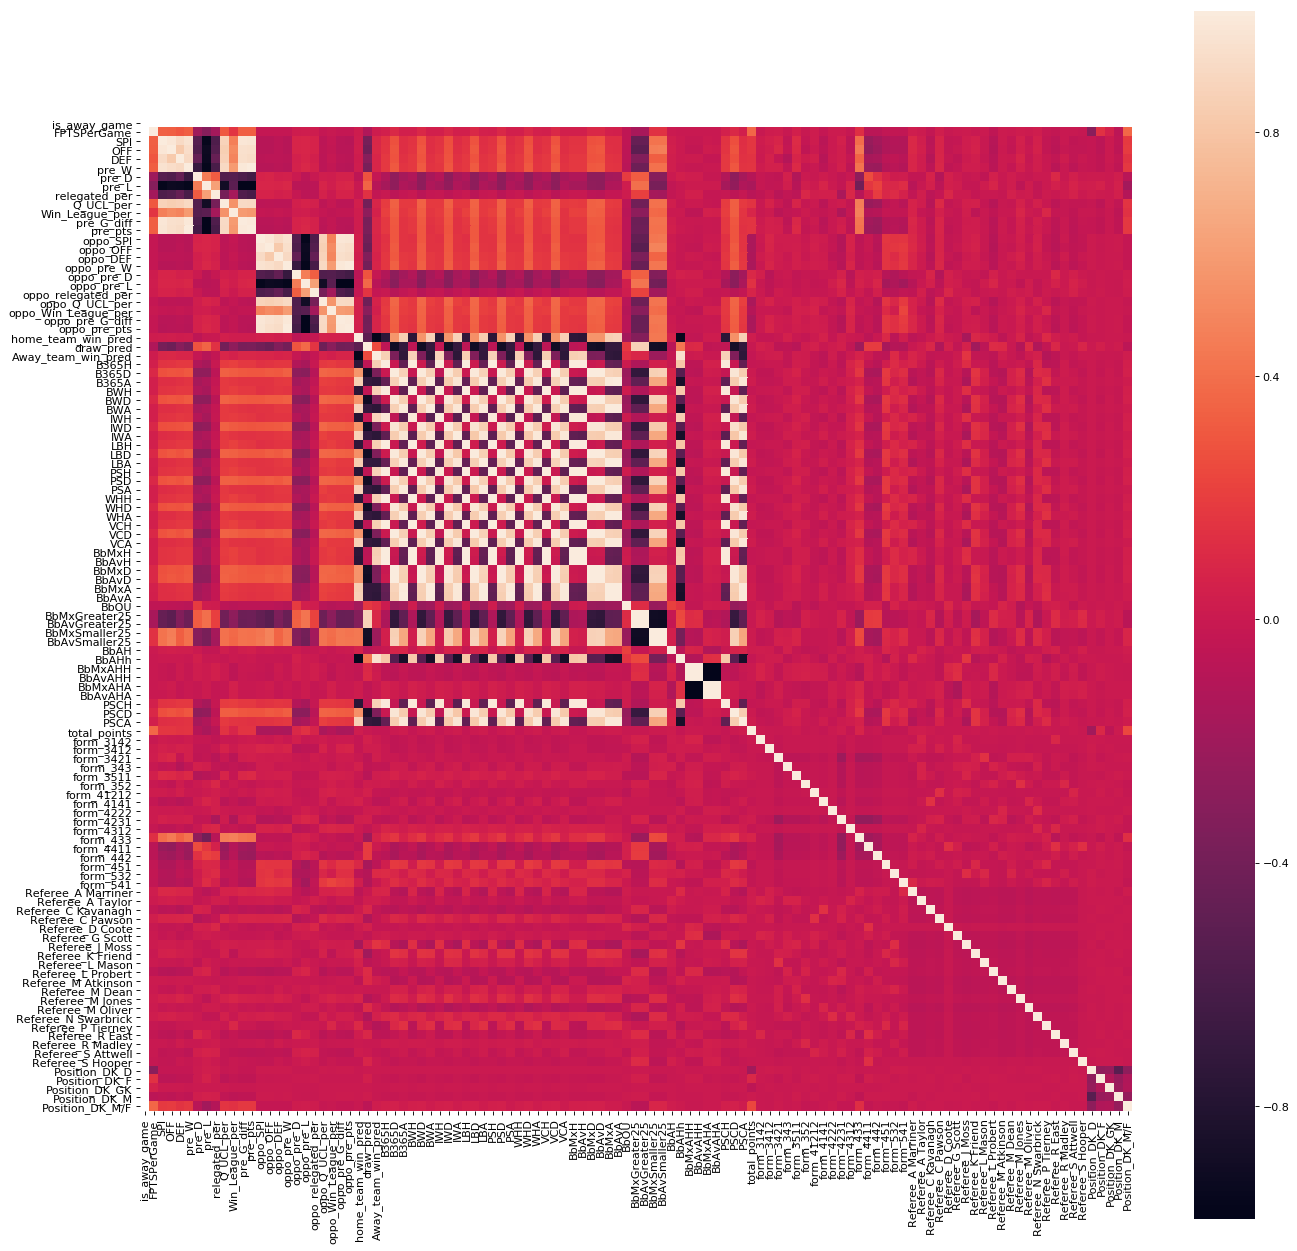

first 10 correlations with total_points total_points       1.000000
FPTSPerGame        0.365312
Position_DK_M/F    0.239185
Position_DK_D      0.192807
SPI                0.164922
OFF                0.163436
pre_G_diff         0.158750
pre_pts            0.155346
pre_W              0.155221
pre_L              0.151596
Name: total_points, dtype: float64


In [47]:
# data correlation
fig=plt.figure(figsize=(20,20), dpi= 80)
corrmat = data_df.corr()
sns.heatmap(corrmat, square=True, xticklabels=True, yticklabels=True)
plt.show()
print('first 10 abs. correlations with total_points', abs(corrmat.total_points).sort_values(ascending=False).head(10))

## Modelling

In [13]:
# Separate training and testing (validating)
last_day_training = '2018-02-28'
train_df = data_df[data_df['game_date'] <= last_day_training]
train_y = train_df['total_points']
train_df = train_df.drop(columns=['total_points'])
test_df = data_df[data_df['game_date'] > last_day_training]
test_y = test_df['total_points']
test_df = test_df.drop(columns=['total_points'])

# keep game_date in a seperate df with player name
game_date_player_name_DK_df = pd.concat([data_df['game_date'], player_name_DK_salary_df], axis =1)

# drop variable: game_date -- not a time-series analysis model
train_df = train_df.drop(columns=['game_date'])
test_df = test_df.drop(columns=['game_date'])

print('training data size', train_df.shape, 'testing data size', test_df.shape)


training data size (4544, 110) testing data size (2202, 110)


In [16]:
# Five-fold cross validation  -- regression with one variable
def r2_cv_FPTSPerGame(model):
    n_folds = 5
    kf = KFold(n_folds, shuffle=True, random_state=0)
    cv_results = cross_validate(model, train_df['FPTSPerGame'].values.reshape(-1, 1), train_y, scoring="r2", cv=kf)
    return (cv_results)

In [17]:
# Five-fold cross validation
def r2_cv(model):
    n_folds = 5
    kf = KFold(n_folds, shuffle=True, random_state=0)
    cv_results = cross_validate(model, train_df.values, train_y, scoring="r2", cv=kf)
    return (cv_results)

### Linear Regression

In [18]:
# linear regression with one variable
linear = LinearRegression()
scores = r2_cv_FPTSPerGame(linear)
print("Linear regression with only historical points per game training score: {:.4f} ({:.4f})".format(scores['train_score'].mean(), scores['train_score'].std()))
print("Linear regression CV testing score: {:.4f} ({:.4f})".format(scores['test_score'].mean(), scores['test_score'].std()))

Linear regression with only historical points per game training score: 0.1369 (0.0040)
Linear regression CV testing score: 0.1348 (0.0157)


In [19]:
# Multi-linear regression
linear = LinearRegression()
scores = r2_cv(linear)
print("Multi-Linear regression training score: {:.4f} ({:.4f})".format(scores['train_score'].mean(), scores['train_score'].std()))
print("Multi-Linear regression CV testing score: {:.4f} ({:.4f})".format(scores['test_score'].mean(), scores['test_score'].std()))

Multi-Linear regression training score: 0.2057 (0.0063)
Multi-Linear regression CV testing score: 0.1579 (0.0280)


### LASSO  Regression

In [20]:
# LASSO  Regression, (1 / (2 * n_samples)) * ||y - Xw||^2_2 + alpha * ||w||_1, L1 regularization
    # you might end up with fewer features included in the model than you started with
    # It is generally used when we have more number of features, because it automatically does feature selection.
lasso = make_pipeline(Lasso(alpha =0.005, random_state=0, max_iter=10000))
scores = r2_cv(lasso)
print("Lasso training score: {:.4f} ({:.4f})".format(scores['train_score'].mean(), scores['train_score'].std()))
print("Lasso regression CV testing score: {:.4f} ({:.4f})".format(scores['test_score'].mean(), scores['test_score'].std()))

Lasso training score: 0.1805 (0.0059)
Lasso regression CV testing score: 0.1728 (0.0217)


### Elastic Net Regression

In [21]:
# Elastic Net Regression, combine LASSO and Ridge
    # 1 / (2 * n_samples) * ||y - Xw||^2_2 + alpha * l1_ratio * ||w||_1 + 0.5 * alpha * (1 - l1_ratio) * ||w||^2_2
ENet = make_pipeline(ElasticNet(alpha=0.005, l1_ratio=.7, random_state=0, max_iter=10000))
scores = r2_cv(ENet)
print("ElasticNet training score: {:.4f} ({:.4f})".format(scores['train_score'].mean(), scores['train_score'].std()))
print("ElasticNet regression CV testing score: {:.4f} ({:.4f})".format(scores['test_score'].mean(), scores['test_score'].std()))

ElasticNet training score: 0.1838 (0.0061)
ElasticNet regression CV testing score: 0.1747 (0.0228)


In [22]:
# Compare coefficients of Multi-linear, Lasso, and ENet
linear = linear.fit(train_df.values, train_y)
lasso = Lasso(alpha =0.005, random_state=0).fit(train_df.values, train_y)
ENet = ElasticNet(alpha=0.005, l1_ratio=0.7, random_state=0).fit(train_df.values, train_y)


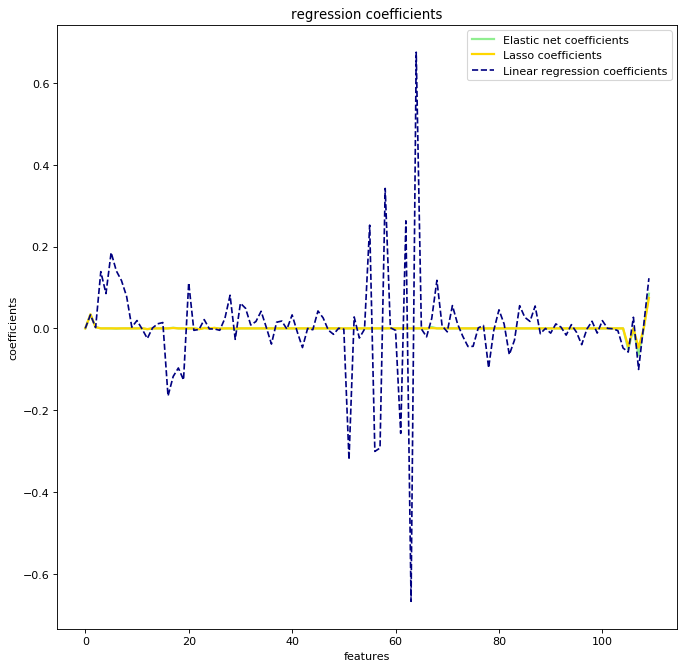

In [23]:
fig=plt.figure(figsize=(10, 10), dpi= 80)
plt.plot(ENet.coef_, color='lightgreen', linewidth=2,
         label='Elastic net coefficients')
plt.plot(lasso.coef_, color='gold', linewidth=2,
         label='Lasso coefficients')
plt.plot(linear.coef_, '--', color='navy', label='Linear regression coefficients')
plt.legend(loc='best')
plt.title('regression coefficients')
plt.xlabel('features')
plt.ylabel('coefficients')
plt.show()

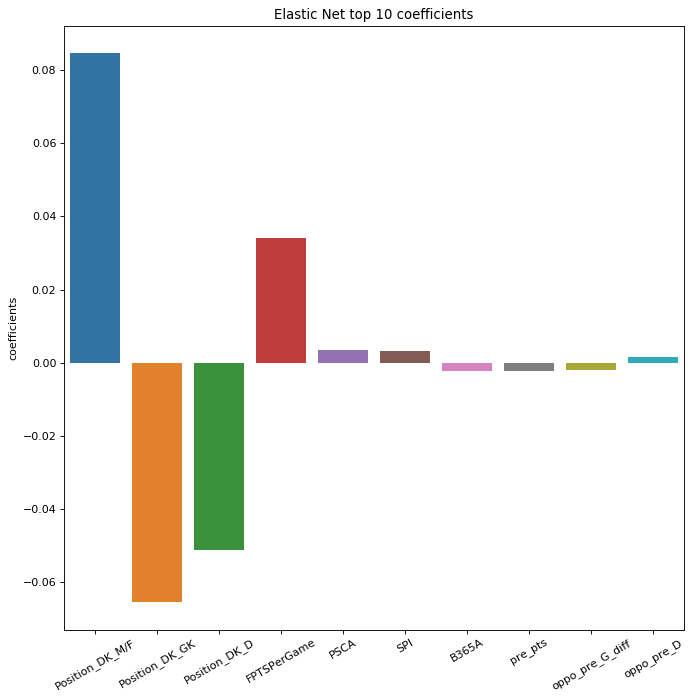

In [24]:
# Bar plot of ENet coefficients
fig=plt.figure(figsize=(10,10), dpi= 80)
a = train_df.columns[np.argsort(abs(ENet.coef_))[-10:][::-1]]
b = ENet.coef_[np.argsort(abs(ENet.coef_))[-10:][::-1]]
g = sns.barplot(x=a, y =b);
g.set_xticklabels(g.get_xticklabels(), rotation=30);
plt.title('Elastic Net top 10 coefficients');
plt.ylabel('coefficients');

### XGBoost: Extreme Gradient Boosting

In [25]:
# XGBoost
model_xgb_no_tune = xgb.XGBRegressor(random_state = 1)
scores = r2_cv(model_xgb_no_tune)
print("XGBoost training score: {:.4f} ({:.4f})".format(scores['train_score'].mean(), scores['train_score'].std()))
print("XGBoost regression CV testing score: {:.4f} ({:.4f})".format(scores['test_score'].mean(), scores['test_score'].std()))

XGBoost training score: 0.3216 (0.0092)
XGBoost regression CV testing score: 0.1784 (0.0170)


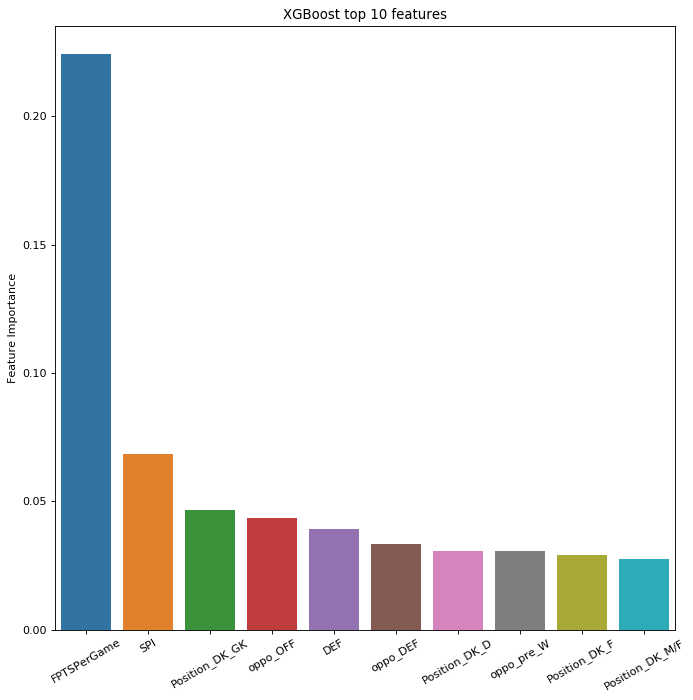

In [26]:
# Important features of XGBoost
model_xgb_no_tune = xgb.XGBRegressor(random_state =1)
model_xgb_no_tune = model_xgb_no_tune.fit(train_df.values, train_y)
model_xgb_no_tune.feature_importances_
fig=plt.figure(figsize=(10,10), dpi= 80)
a = train_df.columns[np.argsort(model_xgb_no_tune.feature_importances_)[-10:][::-1]]
b = model_xgb_no_tune.feature_importances_[np.argsort(model_xgb_no_tune.feature_importances_)[-10:][::-1]]
g = sns.barplot(x=a, y =b);
g.set_xticklabels(g.get_xticklabels(), rotation=30);
plt.title('XGBoost top 10 features');
plt.ylabel('Feature Importance');

#### Fine tune model

In [29]:
# XGBoost fine tune: n_estimators selection
training_scores = []
testing_scores = []
for para_n_estimators in range(30,150,10):
    model_xgb_no_tune = xgb.XGBRegressor(n_estimators=para_n_estimators, random_state =1)
    scores = r2_cv(model_xgb_no_tune)
    print('n_estimators=', para_n_estimators, "Xgboost training score: {:.4f} ({:.4f})".format(scores['train_score'].mean(), scores['train_score'].std()))
    print('n_estimators=', para_n_estimators, "Xgboost regression CV testing score: {:.4f} ({:.4f})".format(scores['test_score'].mean(), scores['test_score'].std()))
    training_scores.append(scores['train_score'].mean())
    testing_scores.append(scores['test_score'].mean())

n_estimators= 30 Xgboost training score: 0.1771 (0.0087)
n_estimators= 30 Xgboost regression CV testing score: 0.1070 (0.0292)
n_estimators= 40 Xgboost training score: 0.2537 (0.0084)
n_estimators= 40 Xgboost regression CV testing score: 0.1696 (0.0235)
n_estimators= 50 Xgboost training score: 0.2724 (0.0077)
n_estimators= 50 Xgboost regression CV testing score: 0.1779 (0.0251)
n_estimators= 60 Xgboost training score: 0.2831 (0.0078)
n_estimators= 60 Xgboost regression CV testing score: 0.1790 (0.0257)
n_estimators= 70 Xgboost training score: 0.2919 (0.0078)
n_estimators= 70 Xgboost regression CV testing score: 0.1799 (0.0261)
n_estimators= 80 Xgboost training score: 0.3001 (0.0077)
n_estimators= 80 Xgboost regression CV testing score: 0.1797 (0.0270)
n_estimators= 90 Xgboost training score: 0.3071 (0.0076)
n_estimators= 90 Xgboost regression CV testing score: 0.1802 (0.0271)
n_estimators= 100 Xgboost training score: 0.3137 (0.0077)
n_estimators= 100 Xgboost regression CV testing score

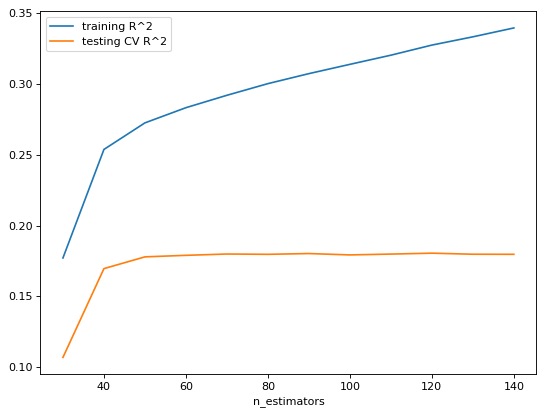

In [30]:
fig=plt.figure(figsize=(8,6), dpi= 80)
sns.lineplot(x=range(30,150,10), y=training_scores, label = 'training R^2');
sns.lineplot(x=range(30,150,10), y=testing_scores, label = 'testing CV R^2');
plt.xlabel('n_estimators');

In [31]:
# define a fine tune function
def para_search(model, param_test):
    kf = KFold(5, shuffle=True, random_state=0)
    gsearch = GridSearchCV(estimator = model, param_grid = param_test, scoring = 'r2', verbose=1, cv=kf, n_jobs = -1)
    gsearch.fit(train_df.values, train_y)
    print('best score: {:.4f}'.format(gsearch.best_score_), 'best parameters:', gsearch.best_params_)

In [32]:
# Fine Tune for the best parameters (n_estimator and learning rate)
param_test1 = {
 'learning_rate': [0.001, 0.01, 0.1, 0.5],
 'n_estimators': range(30, 150, 20)
}
para_search(xgb.XGBRegressor(random_state=1), param_test1)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  1.0min finished


best score: 0.1802 best parameters: {'learning_rate': 0.1, 'n_estimators': 90}


In [66]:
# Tune for the best parameters (max_depth and min_child_weight)
param_test1 = {
 'max_depth':range(1,10,2),
 'min_child_weight':range(1,6,2)
}
para_search(xgb.XGBRegressor(learning_rate=0.1, n_estimators=90, random_state=1), param_test1)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:   11.1s finished


best score: 0.1798 best parameters: {'max_depth': 3, 'min_child_weight': 5}


In [67]:
# Fine Tune for the best parameters (max_depth and min_child_weight)
param_test1 = {
 'max_depth': [2, 3, 4],
 'min_child_weight': [4, 5, 6]
}
para_search(xgb.XGBRegressor(learning_rate=0.1, n_estimators=90, random_state=1), param_test1)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    3.8s finished


best score: 0.1798 best parameters: {'max_depth': 3, 'min_child_weight': 6}


In [68]:
# Tune for the best parameters (gamma)
param_test1 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
para_search(xgb.XGBRegressor(learning_rate=0.1, n_estimators=90, random_state=1, max_depth=3, min_child_weight=6), param_test1)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    2.4s finished


best score: 0.1814 best parameters: {'gamma': 0.2}


In [69]:
# Tune for the best parameters (subsample and colsample_bytree)
param_test1 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
para_search(xgb.XGBRegressor(learning_rate=0.1, n_estimators=90, random_state=1, max_depth=3, min_child_weight=6, gamma=0.2), param_test1)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    6.1s finished


best score: 0.1819 best parameters: {'colsample_bytree': 0.7, 'subsample': 0.9}


In [75]:
# Tune for the best parameters (Regularization Parameters)
param_test1 = {
 'reg_alpha':[1e-5, 1e-3, 0.1, 1, 10, 100]
}
para_search(xgb.XGBRegressor(learning_rate=0.1, n_estimators=90, random_state=1, max_depth=3, min_child_weight=6, gamma=0.2, colsample_bytree=0.7), param_test1)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    1.8s finished


best score: 0.1841 best parameters: {'reg_alpha': 1}


In [27]:
# Fine tuned XGBoost model
model_xgb_tuned = xgb.XGBRegressor(learning_rate=0.1, n_estimators=90, max_depth=3, min_child_weight=6, gamma=0.2, colsample_bytree=0.7, reg_alpha=1, random_state=1)
scores = r2_cv(model_xgb_tuned)
print("Tuned XGBoost training score: {:.4f} ({:.4f})".format(scores['train_score'].mean(), scores['train_score'].std()))
print("XGBoost regression CV testing score: {:.4f} ({:.4f})".format(scores['test_score'].mean(), scores['test_score'].std()))

Tuned XGBoost training score: 0.2905 (0.0062)
XGBoost regression CV testing score: 0.1859 (0.0183)


## Conclusion: This is a highly stochastic process, however, machine learning methods do offer prediction power (if tuned properly) 
![alt text](DK_User_stats.png "Title") <br/>
data from: Draftkings.com

<br/> <br/>

## Future Directions <br/>
### Data Collection: 
#### More data points: player historical data previous seasons
#### More features: game importance to teams <br/> <br/>
### Modelling:
#### Consider Model Stacking
#### Time Series Analysis to pick up trends
<br/> <br/>
<br/> <br/>
<br/> <br/>